[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

# Neural Nets for Neural Images: Assessing Brain Age with Computer Vision
### Contributors: Dr. Jeffrey Petrella, Maria Williams

This project uses transfer learning to train a ResNet18 model to identify the age of a brain from its MRI scan. This kind of identification could potentially be used to flag various congnitive disorders such as Alzhiemers Disease if the "brain age" is identified as more advanced than the patient's chronological age.

### Step 1: Link Notebook to GitHub

In [1]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "BrainAgingComputerVision" # Enter repo name
git_path = 'https://github.com/MRWilliamsGit/BrainAgingComputerVision.git'
!git clone "{git_path}"

Cloning into 'BrainAgingComputerVision'...
remote: Enumerating objects: 395, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 395 (delta 9), reused 23 (delta 9), pack-reused 371
Receiving objects: 100% (395/395), 300.66 MiB | 22.54 MiB/s, done.
Resolving deltas: 100% (176/176), done.


### Step 2: Install and Import Dependencies

In [3]:
#If an error regarding zipfile appears, simply run block again
!pip3 install -r "{os.path.join(repo_name,'requirements.txt')}"  > /dev/null

import os
import shutil
import numpy as np
import pandas as pd
import torch
from google.colab import drive
from google.colab import files
from matplotlib import pyplot as plt
from PIL import Image

from BrainAgingComputerVision.scripts.loaders import RegressionLoaders, SingleLoader
from BrainAgingComputerVision.scripts.Rpredicting import BatchPredict, SinglePredict

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 6.4.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
coveralls 0.5 requires coverage<3.999,>=3.6, but you have coverage 6.4.1 which is incompatible.


### Step 3: Load Model and Demo Images

This Model is a ResNet18 model that has been updated and trained with an average MAE of 5 years over 10 test sets.  

There are 10 images provided in image_data.zip for demonstration purposes: 





![](https://raw.githubusercontent.com/MRWilliamsGit/BrainAgingComputerVision/main/images/examples.png?raw=true)

In [33]:
#unzip example images
!unzip '/content/BrainAgingComputerVision/sample_data/image_data.zip' > /dev/null
images = [f for f in os.listdir('/content') if os.path.isfile(os.path.join('/content', f))]

In [5]:
#get image metadata
filein = '/content/BrainAgingComputerVision/sample_data/cn_age_df.csv'
CNdata = pd.read_csv(filein)
filein = '/content/BrainAgingComputerVision/sample_data/ad_age_df.csv'
ADdata = pd.read_csv(filein)

In [6]:
#load model
model = torch.load('/content/BrainAgingComputerVision/models/model.pt')

### Step 4: Choose Image 

In [23]:
#define image display
def viz(pick):
  #open the image
  here = os.path.join('/content/',images[pick-1])
  image_3D = np.load(here)
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)

  #plot the image
  plt.imshow(im, interpolation='nearest', cmap='gray')
  imgn = images[pick-1].split(".")[0]
  line = CNdata.loc[CNdata['Data ID'] == imgn]
  if len(line)>0:
    label = line.iloc[0][5]
    plt.title("Age: " + str(label)+ " (" +str(imgn) +")")
    plt.axis('off');
  else:
    line = ADdata.loc[ADdata['Data ID'] == imgn]
    label = line.iloc[0][5]
    plt.title("Age: " + str(label)+ "(" +str(imgn) +")")
    plt.axis('off');  


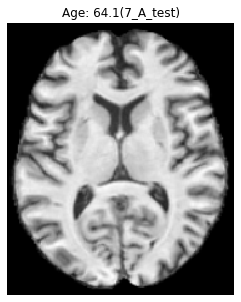

In [36]:
#Pick one of the 10 images to see it and see its age
viz(0)

### Step 5: Get Prediction!

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#get prediction
img = (image_3D[85] * 255).astype(np.uint8)
image = SingleLoader(img)
pred = SinglePredict(model, image, device)
print("Pred: "+str(pred))

Pred: 85.4


### Step 6: AD Application

This model has been trained on cognitively normal subjects, but it interests us to see how this model would perform on subjects with degenerative brain disease such as Alzheimer's. Would the model estimate the brain to be older than it is chronologically?

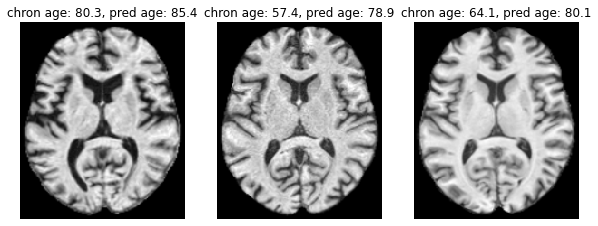

In [45]:
#get AD images
!unzip '/content/BrainAgingComputerVision/sample_data/image_data_AD.zip' > /dev/null
images = ['2_N_test.npy', '4_T_test.npy', '7_A_test.npy']

#show them with their predictions
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 3)
i=0
for m in range(len(images)):
  #open the image
  here = os.path.join('/content/',images[m])
  image_3D = np.load(here)
  forpred = (image_3D[85] * 255).astype(np.uint8)
  #get prediction
  image = SingleLoader(forpred)
  pred = SinglePredict(model, image, device)
  #plot the image
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)
  axs[m].imshow(im, interpolation='nearest', cmap='gray')
  imgn = images[m].split(".")[0]
  line = ADdata.loc[ADdata['Data ID'] == imgn]
  label = line.iloc[0][5]
  axs[m].set_title("chron age: " + str(label) + ", pred age: " + str(pred))
  axs[m].axis('off') 
